# Normality test

Here in this notebook, we test the normality of the triplet accuracy. 
Thus, we simulate triplets from a ground-truth scale (as described in the paper) and predict a scale with SOE. 
We plot 100 accuracy samples from repeated CV and from independent test sets and apply a hypothesis test for normality (https://docs.scipy.org/doc/scipy-1.8.0/reference/generated/scipy.stats.normaltest.html). 

In [6]:
import numpy as np
from cblearn import datasets, metrics, embedding
import matplotlib.pyplot as plt
from scipy.stats import normaltest, kstest
import seaborn as sns
from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn.model_selection import train_test_split
from tripletdim.data.datasets import make_triplets
import tqdm


sns.set_theme('talk', 'white')

In [7]:
noise_sd = 1
n_triplets = 2000
n_splits = 10
n_repeats = 10
n_samples = n_splits * n_repeats

meta, T, T_test = make_triplets('normal-3-60', n_triplets=n_triplets, n_test_triplets=n_triplets * n_samples, noise_sd=noise_sd, random_state=42)
dim = meta['n_dimension']
meta

{'name': 'normal-3-60',
 'n_dimension': 3,
 'distance': 'euclidean',
 'subject': '',
 'n_objects': 60,
 'n_train_triplets': 2000,
 'n_test_triplets': 200000,
 'frac_train_ndlogn': 2.7137704075108036,
 'frac_train_triplets': 0.01948178453146308,
 'max_train_score': 0.783,
 'max_test_score': 0.78833,
 'noise_sd': 1,
 'distance_sd': 1.0399730425670826,
 'distance_mean': 2.4071612243556086,
 'difference_sd': 0.9365820724790842,
 'difference_mean': -0.10241361126363709,
 'random_state': 42}

In [8]:
def accuracy_distribution():
    Ts = (_make_random_triplets(X, size=n_triplets, result_format='list-order')
         for _ in range(n_samples))
    accs = np.array([metrics.query_accuracy(T, datasets.triplet_response(T, X, 'list-order')) for T in Ts])
    return accs

true_dist = np.array([embedding.SOE(dim).fit(train).score(test) for train, test in 
                      (train_test_split(T_test_sample, test_size = 1 / n_splits)
                       for T_test_sample in tqdm.tqdm(np.split(T_test, n_samples)))])
#true_dist = accuracy_distribution()

100%|██████████| 100/100 [09:37<00:00,  5.77s/it]


In [23]:
cv_dist = cross_val_score(embedding.SOE(dim), T, cv=RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats), verbose=True, n_jobs=2)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  3.5min
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:  7.6min finished


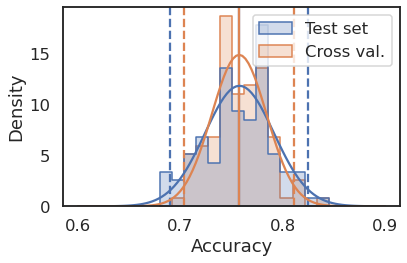

In [50]:
true_mean, true_std = (true_dist.mean(), true_dist.std(ddof=1))
cv_mean, cv_std = (cv_dist.mean(), cv_dist.std(ddof=1))

plt.xlabel('Accuracy')
plt.axvline(true_mean, color=sns.color_palette()[0])
plt.axvline(true_mean - 2 * true_std, ls='--', color=sns.color_palette()[0])
plt.axvline(true_mean + 2 *true_std, ls='--', color=sns.color_palette()[0])

plt.axvline(cv_mean, color=sns.color_palette()[1])
plt.axvline(cv_mean - 2 * cv_std, ls='--', color=sns.color_palette()[1])
plt.axvline(cv_mean + 2 * cv_std, ls='--', color=sns.color_palette()[1])

from scipy.stats import norm
x = np.linspace(0.6, 0.9, 100)
y = norm.pdf(x, true_mean, true_std)
plt.plot(x, y)
y = norm.pdf(x, cv_mean, cv_std)
plt.plot(x, y)

sns.histplot({'Test set': true_dist, 'Cross val.': cv_dist}, stat='density', common_norm=False, multiple='layer', element='step')
plt.tight_layout()
plt.savefig('../tex/plots/cv-normal.pdf')

In [25]:
# null hypothesis: x comes from a normal distribution
normaltest(true_dist), normaltest(cv_dist)

(NormaltestResult(statistic=0.46802836075055365, pvalue=0.7913505941676191),
 NormaltestResult(statistic=2.4638397170755524, pvalue=0.29173195560980264))